In [9]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import ast
from functools import partial
import nltk

Use WordNet similarity score to find probabilitiy corresponding to the closest label 

In [11]:
from nltk.corpus import wordnet

In [21]:
df = pd.read_csv('vgg_scores_wordnet_id.csv',index_col=0)

Input dataframe columns: (see alexnet.ipynb for getting wordnet ids for corresponding labels)

In [22]:
df.columns

Index(['type', 'dir', 'id_labels', 'readable_labels'], dtype='object')

In [23]:
# manually select the synsnet with the correct definition for each type
type_names = np.unique(df['type'].values)
for t in type_names:
    syns = wordnet.synsets(t.lower())
    print(f'{t}: ')
    for s in syns:
        print(s)
        print(s.definition())
    print()

Banana: 
Synset('banana.n.01')
any of several tropical and subtropical treelike herbs of the genus Musa having a terminal crown of large entire leaves and usually bearing hanging clusters of elongated fruits
Synset('banana.n.02')
elongated crescent-shaped yellow fruit with soft sweet flesh

Beach: 
Synset('beach.n.01')
an area of sand sloping down to the water of a sea or lake
Synset('beach.v.01')
land on a beach

Car: 
Synset('car.n.01')
a motor vehicle with four wheels; usually propelled by an internal combustion engine
Synset('car.n.02')
a wheeled vehicle adapted to the rails of railroad
Synset('car.n.03')
the compartment that is suspended from an airship and that carries personnel and the cargo and the power plant
Synset('car.n.04')
where passengers ride up and down
Synset('cable_car.n.01')
a conveyance for passengers or freight on a cable railway

Church: 
Synset('church.n.01')
one of the groups of Christians who have their own beliefs and forms of worship
Synset('church.n.02')
a 

In [24]:
type_synsets = ['banana.n.02','beach.n.01','car.n.01','church.n.02','beacon.n.03','mountain.n.01','coffee_mug.n.01','airplane.n.01']
type_final = {type_names[i] : type_synsets[i] for i in range(len(type_names))}

In [25]:
type_final

{'Banana': 'banana.n.02',
 'Beach': 'beach.n.01',
 'Car': 'car.n.01',
 'Church': 'church.n.02',
 'Lighthouse': 'beacon.n.03',
 'Mountain': 'mountain.n.01',
 'Mug': 'coffee_mug.n.01',
 'Plane': 'airplane.n.01'}

In [26]:
# compute similarity score between synsets of each of the top 10 labels and the type 
def getSyns(similarity,closest,row):
    # type name
    category = row['type'] 
    
    # top 10 labels' ids in wordnet
    labels  = row['id_labels'] 
    labels = ast.literal_eval(labels)
    key = labels.keys() 
    
    # iterate through top 10 labels and compare with type 
    sim = dict()
    notFound = True
    for k in key:
        pos, synid = k.split('-')[1], int(k.split('-')[0]) # part of speech (all noun in this case), id
        k_syns = wordnet.synset_from_pos_and_offset(pos, synid) # label synsets
        cat_syns = wordnet.synset(type_final[category]) # type synsets
        s = k_syns.path_similarity(cat_syns)
        sim[k] = s
        
        # find the first > 0.5 similarity label among the top 10
        if s >= 0.5 and notFound:
            closest.append({k:s})
            notFound = False
            
    # return the label with highest probabilitiy if none is above 0.5
    if notFound:
        sim_np = np.array(sim.values())
        max_key = list(key)[np.argmax(sim_np)]
        closest.append({max_key : sim[max_key]})
    
    similarity.append(sim)

In [27]:
# read labels to wordnet synsets
ltw = pd.read_json('../imagenet_label_to_wordnet_synset.json').T

In [28]:
# get readable labels from imagenet_label_to_wordnet_synset.json
def convertIdToReadable(id_label):
    for idx in range(ltw.shape[0]):
        if ltw['id'][idx] == id_label:
            return ltw['label'][idx]
    return None

In [29]:
df

,type,dir,id_labels,readable_labels
0,Mountain,../Image/All_Cropped\Mountain\1.jpg,"{'09332890-n': 0.33909276127815247, '09468604-...","{'lakeside': 0.33909276127815247, 'valley': 0...."
1,Mountain,../Image/All_Cropped\Mountain\10.jpg,"{'09468604-n': 0.38023269176483154, '09193705-...","{'valley': 0.38023269176483154, 'alp': 0.21241..."
2,Mountain,../Image/All_Cropped\Mountain\11.jpg,"{'09193705-n': 0.6954638361930847, '09472597-n...","{'alp': 0.6954638361930847, 'volcano': 0.18501..."
3,Mountain,../Image/All_Cropped\Mountain\12.jpg,"{'09193705-n': 0.5897970795631409, '09468604-n...","{'alp': 0.5897970795631409, 'valley': 0.335895..."
4,Mountain,../Image/All_Cropped\Mountain\13.jpg,"{'09246464-n': 0.49911436438560486, '09399592-...","{'cliff': 0.49911436438560486, 'promontory': 0..."
...,...,...,...,...
123,Church,../Image/All_Cropped\Church\5.jpg,"{'03028079-n': 0.4907413423061371, '02825657-n...","{'church': 0.4907413423061371, 'bell cote': 0...."
124,Church,../Image/All_Cropped\Church\6.jpg,"{'02793495-n': 0.9191867113113403, '03028079-n...","{'barn': 0.9191867113113403, 'church': 0.03191..."
125,Church,../Image/All_Cropped\Church\7.jpg,"{'03781244-n': 0.6467804312705994, '03028079-n...","{'monastery': 0.6467804312705994, 'church': 0...."
126,Church,../Image/All_Cropped\Church\8.jpg,"{'03028079-n': 0.4047333896160126, '02859443-n...","{'church': 0.4047333896160126, 'boathouse': 0...."


In [30]:
similarity = []
closest = []
getSynsPartial = partial(getSyns, similarity, closest)
df.apply(getSynsPartial, axis=1)

df['similarity_score'] = similarity
df['closest_id_label'] = [list(item.keys())[0] for item in closest]
df['closest_similarity_score'] = [list(item.values())[0] for item in closest]
df['closest_readable_label'] = df['closest_id_label'].apply(convertIdToReadable)
df['closest_prob'] = [ast.literal_eval(d)[i] for d, i in zip(df['id_labels'],df['closest_id_label'])]

In [31]:
df

,type,dir,id_labels,readable_labels,similarity_score,closest_id_label,closest_similarity_score,closest_readable_label,closest_prob
0,Mountain,../Image/All_Cropped\Mountain\1.jpg,"{'09332890-n': 0.33909276127815247, '09468604-...","{'lakeside': 0.33909276127815247, 'valley': 0....","{'09332890-n': 0.2, '09468604-n': 0.2, '031603...",09472597-n,0.5,volcano,0.053892
1,Mountain,../Image/All_Cropped\Mountain\10.jpg,"{'09468604-n': 0.38023269176483154, '09193705-...","{'valley': 0.38023269176483154, 'alp': 0.21241...","{'09468604-n': 0.2, '09193705-n': 0.5, '093328...",09193705-n,0.5,alp,0.212414
2,Mountain,../Image/All_Cropped\Mountain\11.jpg,"{'09193705-n': 0.6954638361930847, '09472597-n...","{'alp': 0.6954638361930847, 'volcano': 0.18501...","{'09193705-n': 0.5, '09472597-n': 0.5, '094686...",09193705-n,0.5,alp,0.695464
3,Mountain,../Image/All_Cropped\Mountain\12.jpg,"{'09193705-n': 0.5897970795631409, '09468604-n...","{'alp': 0.5897970795631409, 'valley': 0.335895...","{'09193705-n': 0.5, '09468604-n': 0.2, '092464...",09193705-n,0.5,alp,0.589797
4,Mountain,../Image/All_Cropped\Mountain\13.jpg,"{'09246464-n': 0.49911436438560486, '09399592-...","{'cliff': 0.49911436438560486, 'promontory': 0...","{'09246464-n': 0.25, '09399592-n': 0.333333333...",09193705-n,0.5,alp,0.088032
...,...,...,...,...,...,...,...,...,...
123,Church,../Image/All_Cropped\Church\5.jpg,"{'03028079-n': 0.4907413423061371, '02825657-n...","{'church': 0.4907413423061371, 'bell cote': 0....","{'03028079-n': 1.0, '02825657-n': 0.1111111111...",03028079-n,1.0,"church, church building",0.490741
124,Church,../Image/All_Cropped\Church\6.jpg,"{'02793495-n': 0.9191867113113403, '03028079-n...","{'barn': 0.9191867113113403, 'church': 0.03191...","{'02793495-n': 0.2, '03028079-n': 1.0, '028594...",03028079-n,1.0,"church, church building",0.031918
125,Church,../Image/All_Cropped\Church\7.jpg,"{'03781244-n': 0.6467804312705994, '03028079-n...","{'monastery': 0.6467804312705994, 'church': 0....","{'03781244-n': 0.14285714285714285, '03028079-...",03028079-n,1.0,"church, church building",0.153239
126,Church,../Image/All_Cropped\Church\8.jpg,"{'03028079-n': 0.4047333896160126, '02859443-n...","{'church': 0.4047333896160126, 'boathouse': 0....","{'03028079-n': 1.0, '02859443-n': 0.1666666666...",03028079-n,1.0,"church, church building",0.404733


In [40]:
df.loc[4]

type                                                                 Mountain
dir                                      ../Image/All_Cropped\Mountain\13.jpg
id_labels                   {'09246464-n': 0.49911436438560486, '09399592-...
readable_labels             {'cliff': 0.49911436438560486, 'promontory': 0...
similarity_score            {'09246464-n': 0.25, '09399592-n': 0.333333333...
closest_id_label                                                   09193705-n
closest_similarity_score                                                  0.5
closest_readable_label                                                    alp
closest_prob                                                        0.0880319
Name: 4, dtype: object

In [41]:
df.loc[9]

type                                                                 Mountain
dir                                       ../Image/All_Cropped\Mountain\3.jpg
id_labels                   {'09288635-n': 0.22686250507831573, '09193705-...
readable_labels             {'geyser': 0.22686250507831573, 'alp': 0.19879...
similarity_score            {'09288635-n': 0.2, '09193705-n': 0.5, '094686...
closest_id_label                                                   09193705-n
closest_similarity_score                                                  0.5
closest_readable_label                                                    alp
closest_prob                                                         0.198793
Name: 9, dtype: object

In [35]:
# df.to_csv('vgg_scores_wordnet_id_closest_label.csv')

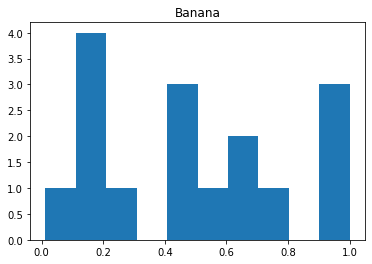

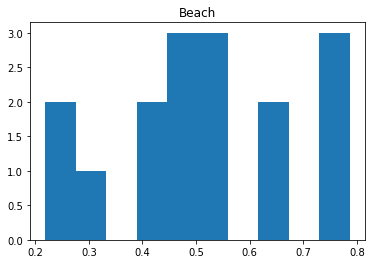

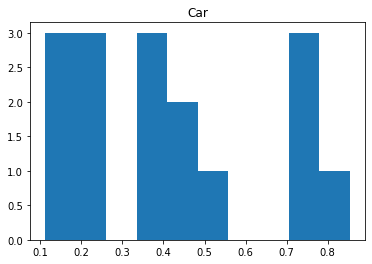

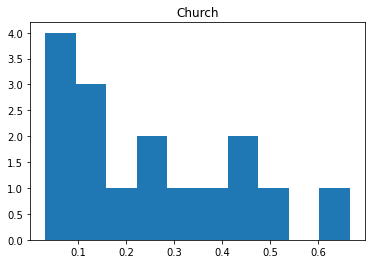

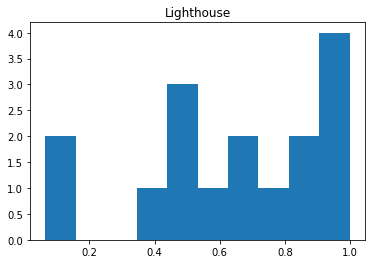

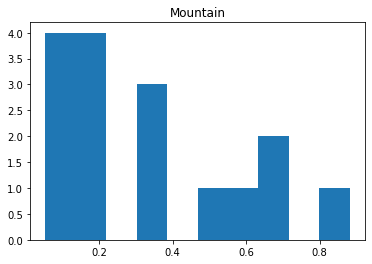

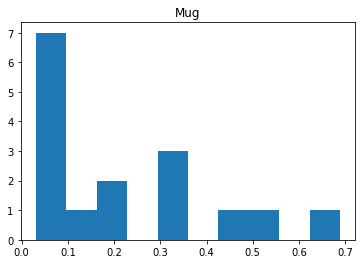

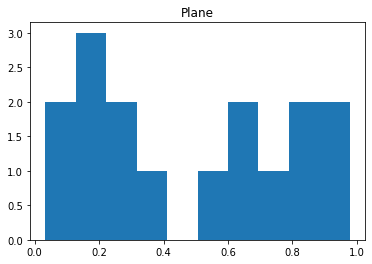

In [39]:
import matplotlib.pyplot as plt

for t in type_names:
    df_plot=df[df['type']==t]
    plt.hist(df_plot['closest_prob'])
    plt.title(t)
    plt.show()